In [2]:
#All packages used
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import ComplementNB
from scipy.stats import uniform
import seaborn as sns

Loading in the dataset

In [3]:
africa_moral_gdp_2 = pd.read_csv('africa_moral_gdp_2.csv')

print(africa_moral_gdp_2)

       AttributeLevel ScenarioTypeStrict ScenarioType  NumberOfCharacters  \
0                More        Utilitarian  Utilitarian                 5.0   
1                Less        Utilitarian  Utilitarian                 1.0   
2                 Fat            Fitness      Fitness                 3.0   
3                 Fit            Fitness      Fitness                 3.0   
4                More        Utilitarian  Utilitarian                 5.0   
...               ...                ...          ...                 ...   
330261           More        Utilitarian  Utilitarian                 5.0   
330262           Rand             Random       Random                 5.0   
330263           Rand             Random       Random                 4.0   
330264        Hoomans            Species      Species                 1.0   
330265           Pets            Species      Species                 1.0   

        Saved UserCountry3  RegionAU  Adult  Pregnant_2  Stroller_2  Elderl

Getting descriptive statistics

In [3]:
# Step 1: Check Column Name
print(africa_moral_gdp_2.columns)

# Use describe() to get the descriptive statistics
column_stats = africa_moral_gdp_2['RegionAU'].describe()

# Print the statistics
print(column_stats)


Index(['AttributeLevel', 'ScenarioTypeStrict', 'ScenarioType',
       'NumberOfCharacters', 'Saved', 'UserCountry3', 'RegionAU', 'Adult',
       'Pregnant_2', 'Stroller_2', 'Elderly', 'Child', 'Homeless_2',
       'Larger Adult', 'Criminal_2', 'Executive', 'Fit Adult', 'Doctor',
       'Animal', '2024'],
      dtype='object')
count       330266
unique           5
top       northern
freq        151590
Name: RegionAU, dtype: object


Creating dummy variables for the REGIONAU feature

In [4]:
# Create dummy variables
region_dummies = pd.get_dummies(africa_moral_gdp_2['RegionAU'], prefix='RegionAU')

# Concatenate the dummy variables with the original dataframe
africa_moral_gdp_2 = pd.concat([africa_moral_gdp_2, region_dummies], axis=1)

# Drop the original 'RegionAU' column
africa_moral_gdp_2.drop('RegionAU', axis=1, inplace=True)


**Decision tree**

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

Accuracy: 0.6081236564023375

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61     32902
           1       0.61      0.61      0.61     33152

    accuracy                           0.61     66054
   macro avg       0.61      0.61      0.61     66054
weighted avg       0.61      0.61      0.61     66054


Feature Importance from most predictive power to least:
              Feature  Importance
9               Child    0.247161
16             Animal    0.163797
8             Elderly    0.105411
7          Stroller_2    0.092106
6          Pregnant_2    0.078072
13          Executive    0.068874
5               Adult    0.064767
14          Fit Adult    0.053213
15             Doctor    0.041735
11       Larger Adult    0.039426
10         Hom

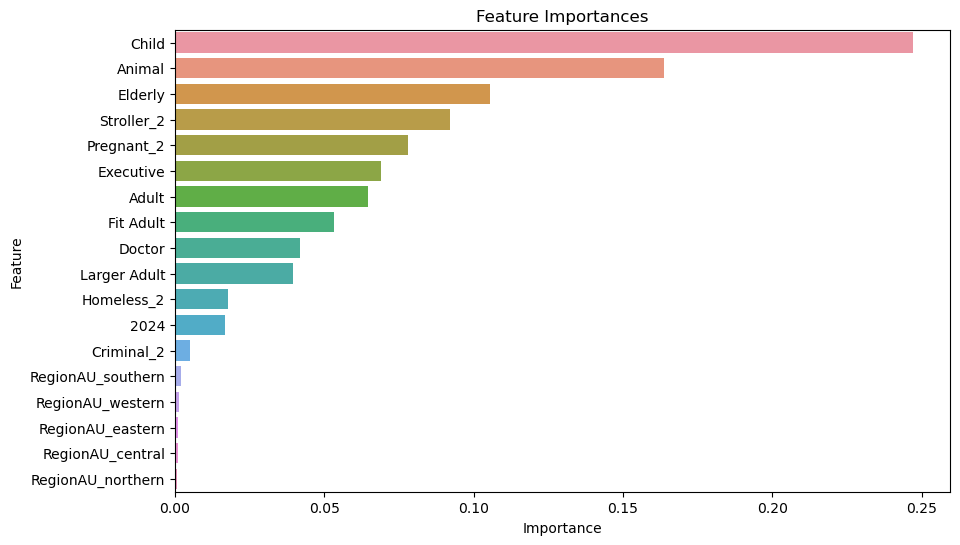

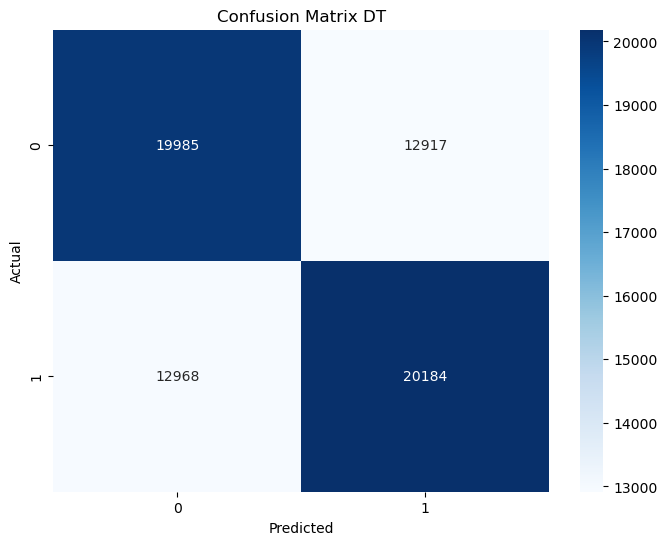


Precision-Recall AUC: 0.7074631817450505


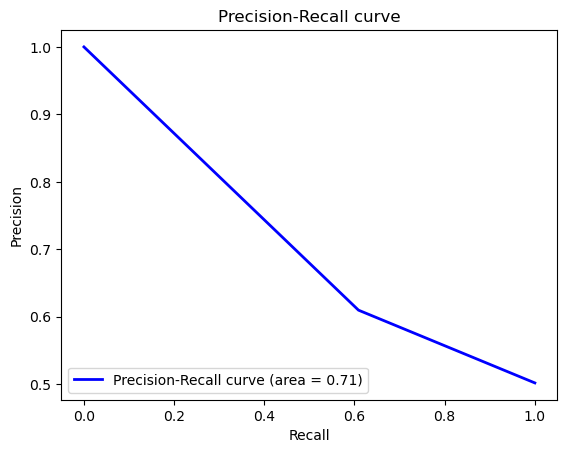

Cross-validation scores: [0.60836588 0.60813286 0.60689144 0.60976791 0.6033791 ]
Mean CV score: 0.6073074398865079


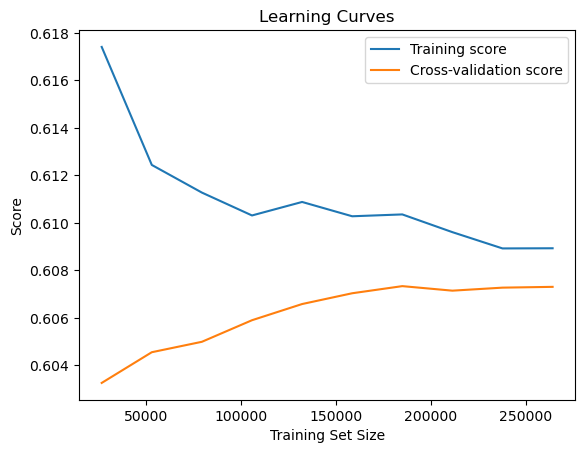

In [23]:
#Model 1: Decision Tree
# Defining features and target variable
features = ['RegionAU_central', 'RegionAU_northern', 'RegionAU_eastern', 'RegionAU_western', 'RegionAU_southern',
            'Adult', 'Pregnant_2', 'Stroller_2', 'Elderly', 'Child', 'Homeless_2', 
            'Larger Adult', 'Criminal_2', 'Executive', 'Fit Adult', 'Doctor', 'Animal', '2024']
X = africa_moral_gdp_2[features]
y = africa_moral_gdp_2['Saved']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train the best model on the training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute feature importance
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance from most predictive power to least:")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix DT')
plt.show()

# Compute Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
print("\nPrecision-Recall AUC:", pr_auc)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# Cross-Validation Scores
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()

**svm**

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'alpha': 0.0006641157902710027, 'loss': 'hinge', 'max_iter': 10000, 'tol': 0.001}
Feature Coefficients:
RegionAU_central: -0.024088765901173342
RegionAU_northern: 0.009765731777784148
RegionAU_eastern: -0.0006195228855009079
RegionAU_western: 0.008298025916612608
RegionAU_southern: -0.009052232312220344
Adult: 0.23798140836218856
Pregnant_2: 0.2785797725366058
Stroller_2: 0.2165140746253519
Elderly: -0.001743109033248703
Child: 0.46620604525463943
Homeless_2: 0.1600899651528473
Larger Adult: 0.05894766933105825
Criminal_2: 0.1627773543556915
Executive: 0.2903275592553118
Fit Adult: 0.3115871298663468
Doctor: 0.21855796732634225
Animal: -0.002651589479169059
2024: 0.012423793341338439

Accuracy: 0.5913797801798528

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.75      0.65     32902
           1       0.64      0.43      0.52     33152

    a

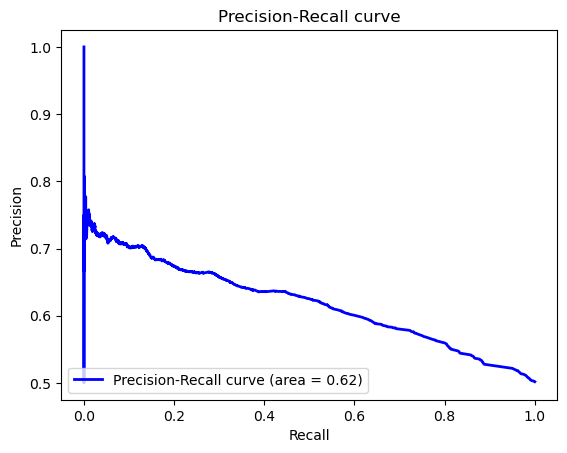

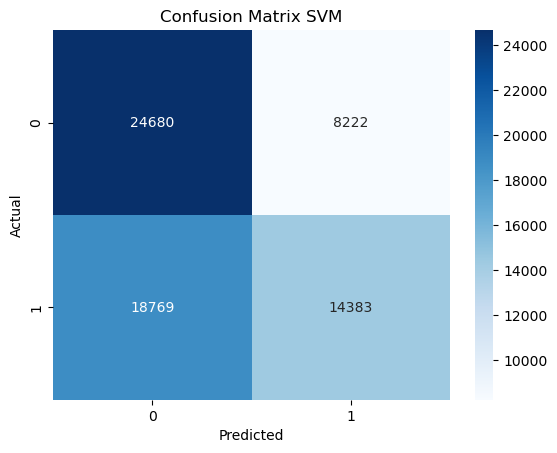


Cross-validation scores: [0.51202047 0.5439874  0.53101297 0.52351899 0.53252691]
Mean CV accuracy: 0.5286133498237231


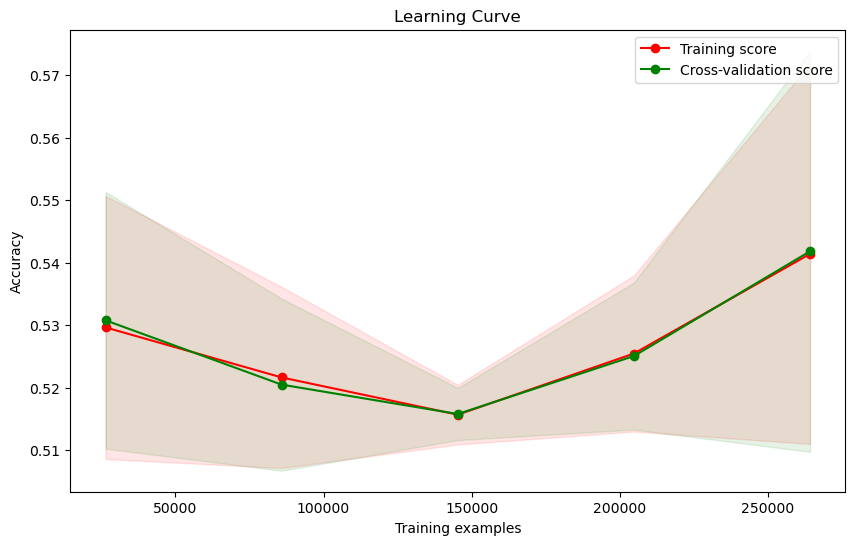

In [24]:
#Model 2: SVM
# Defining features and target variable
features = ['RegionAU_central', 'RegionAU_northern', 'RegionAU_eastern', 'RegionAU_western', 'RegionAU_southern',
            'Adult', 'Pregnant_2', 'Stroller_2', 'Elderly', 'Child', 'Homeless_2', 
            'Larger Adult', 'Criminal_2', 'Executive', 'Fit Adult', 'Doctor', 'Animal', '2024']
X = africa_moral_gdp_2[features]
y = africa_moral_gdp_2['Saved']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defining the parameter distribution for RandomizedSearchCV
param_dist = {
    'alpha': uniform(loc=1e-4, scale=1e-2),  # Regularization parameter
    'max_iter': [5000, 10000, 20000],  # Increased max_iter values
    'tol': [1e-4, 1e-3],  # Different tolerances
    'loss': ['hinge'],  # Hinge loss for SVM
}

# Initialize the SGDClassifier model
sgd_model = SGDClassifier(random_state=42)

# Initialize GridSearchCV with fewer iterations for faster results
random_search = RandomizedSearchCV(sgd_model, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1)

# Fit GridSearchCV
random_search.fit(X_train_scaled, y_train)

# Get the best model
best_sgd_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Predict on the testing set with the best model
y_pred = best_sgd_model.predict(X_test_scaled)
y_pred_proba = best_sgd_model.decision_function(X_test_scaled)  # For precision-recall curve

# Get feature coefficients
feature_coefficients = best_sgd_model.coef_[0]

# Print feature coefficients
print("Feature Coefficients:")
for feature, coefficient in zip(features, feature_coefficients):
    print(f"{feature}: {coefficient}")

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print("\nPrecision-Recall AUC:", pr_auc)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix SVM')
plt.show()

# Perform cross-validation
cv_scores = cross_val_score(best_sgd_model, X, y, cv=5)  # Reducing the number of CV folds
print("\nCross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_sgd_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

**naive bayes**

Best Hyperparameters: {'alpha': 0.1, 'norm': False}

Accuracy: 0.590683380264632

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.66      0.62     32902
           1       0.61      0.52      0.56     33152

    accuracy                           0.59     66054
   macro avg       0.59      0.59      0.59     66054
weighted avg       0.59      0.59      0.59     66054


Precision-Recall AUC: 0.6171607941657279


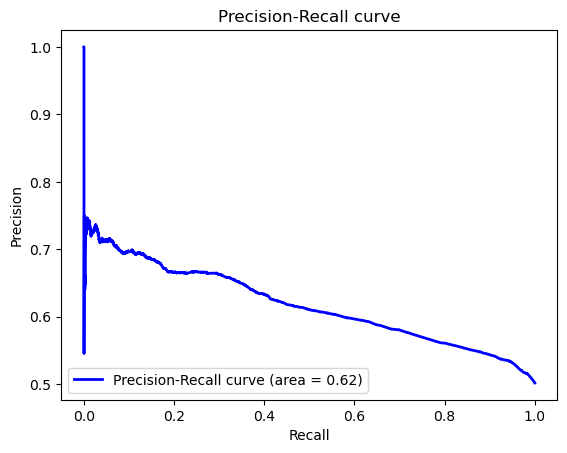

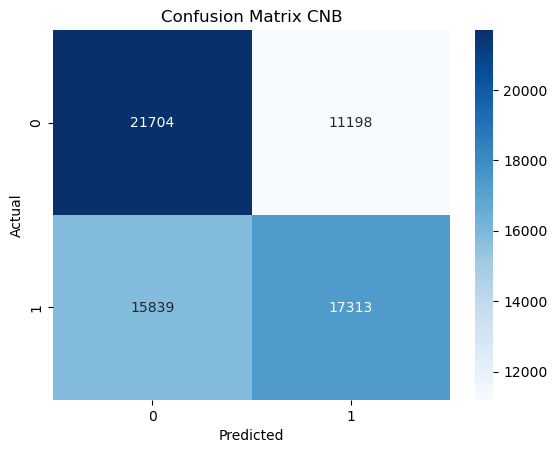


Cross-validation scores: [0.58871529 0.58870907 0.58914811 0.59010189 0.58678637]
Mean CV accuracy: 0.5886921450492981


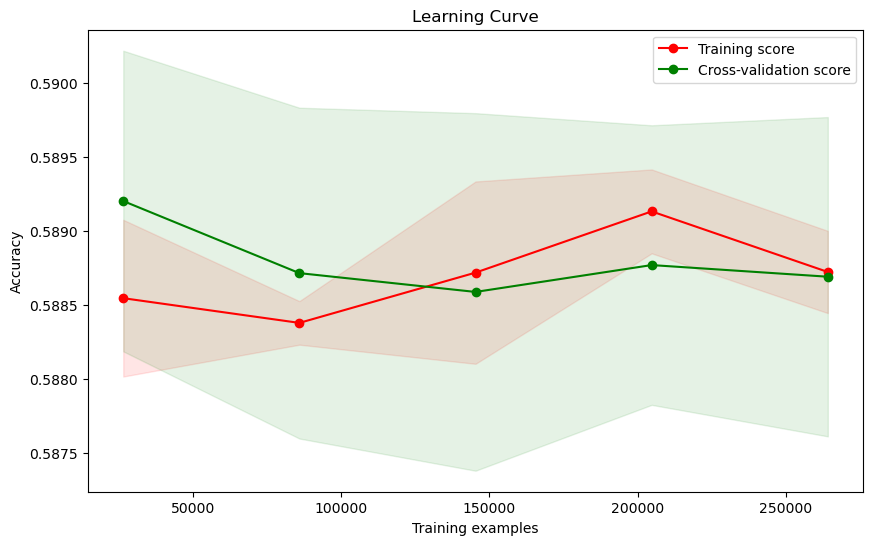


Feature Importance:
RegionAU_central: -0.09804574310496239
RegionAU_northern: -0.1040721359347625
RegionAU_eastern: -0.1047157944239383
RegionAU_western: -0.10720171762145636
RegionAU_southern: -0.10399227837240099
Adult: 0.1503543392400397
Pregnant_2: 0.560054865568663
Stroller_2: 0.570739339729299
Elderly: -0.4278854144090749
Child: 0.6779895615303975
Homeless_2: 0.23314483060569646
Larger Adult: -0.1264574685320361
Criminal_2: 0.262545830962992
Executive: 0.3795965705295834
Fit Adult: 0.15554851390521218
Doctor: 0.16988494872707305
Animal: -1.018074040256904
2024: -0.10415082358133221


In [25]:
# Model 3: CNB

# Defining features and target variable
features = ['RegionAU_central', 'RegionAU_northern', 'RegionAU_eastern', 'RegionAU_western', 'RegionAU_southern',
            'Adult', 'Pregnant_2', 'Stroller_2', 'Elderly', 'Child', 'Homeless_2', 
            'Larger Adult', 'Criminal_2', 'Executive', 'Fit Adult', 'Doctor', 'Animal', '2024']
X = africa_moral_gdp_2[features]
y = africa_moral_gdp_2['Saved']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (ComplementNB works with positive features, so scaling must ensure non-negative values)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure non-negative values for Naive Bayes
X_train_scaled = X_train_scaled - X_train_scaled.min(axis=0)
X_test_scaled = X_test_scaled - X_test_scaled.min(axis=0)

# Defining the model and parameters for GridSearchCV
cnb = ComplementNB()
params = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'norm': [False, True]
}
grid_search = GridSearchCV(cnb, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_cnb = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Predict on the testing set with the best estimator
y_pred = best_cnb.predict(X_test_scaled)
y_pred_proba = best_cnb.predict_proba(X_test_scaled)[:, 1]  # Get the probabilities for the positive class

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print("\nPrecision-Recall AUC:", pr_auc)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix CNB')
plt.show()

# perform cross-validation
cv_scores = cross_val_score(best_cnb, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_cnb, X, y, cv=5, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()


# Extract feature importance
# The complement Naive Bayes model's feature importance can be interpreted from the feature log probabilities.
feature_importance = best_cnb.feature_log_prob_[1] - best_cnb.feature_log_prob_[0]

# Print feature importance
print("\nFeature Importance:")
for feature, importance in zip(features, feature_importance):
    print(f"{feature}: {importance}")


Plotting for Conclusion

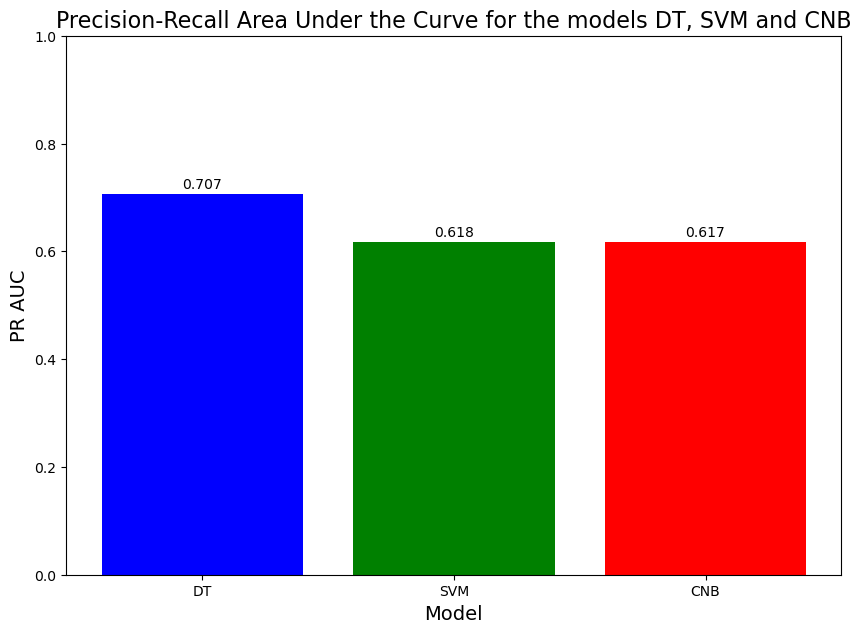

In [22]:
# Model Comparison PRAUC PLOT 

# PR AUC values for the three models
models = ['DT', 'SVM', 'CNB']
pr_auc = [0.707, 0.618, 0.617]

plt.figure(figsize=(10, 7))

# Plotting the PR AUC values
plt.bar(models, pr_auc, color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('PR AUC', fontsize=14)
plt.title('Precision-Recall Area Under the Curve for the models DT, SVM and CNB', fontsize=16)
plt.ylim(0, 1)

# Display the values on top of each bar
for i, v in enumerate(pr_auc):
    plt.text(i, v + 0.01, str(v), ha='center')

plt.show()



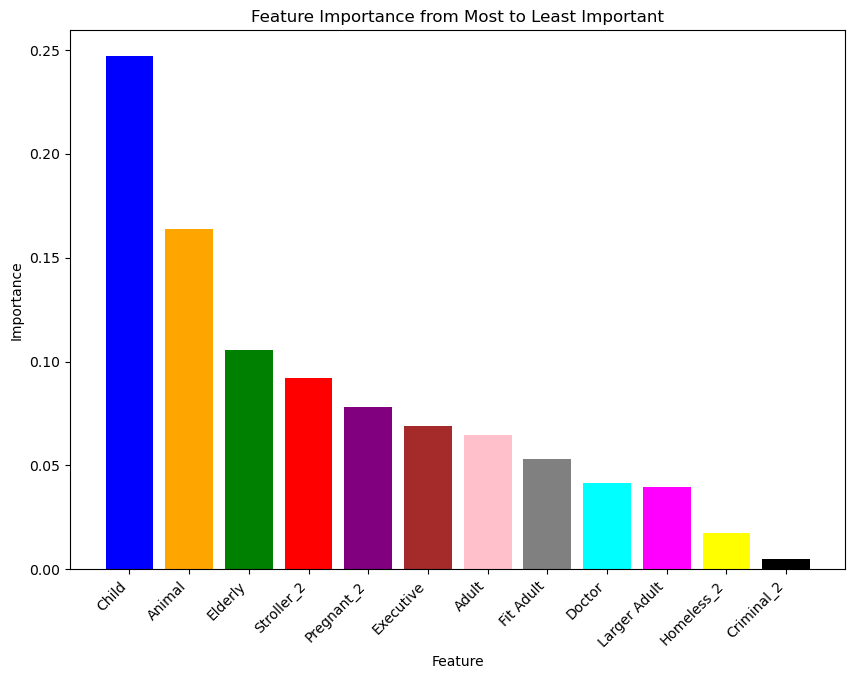

In [11]:
#Plotting Feature Importance from Decision Tree

# Feature names and importance values
features = ['Child', 'Animal', 'Elderly', 'Stroller_2', 'Pregnant_2', 'Executive', 'Adult', 'Fit Adult', 'Doctor', 'Larger Adult', 'Homeless_2', 'Criminal_2']
importance_values = [0.247161, 0.163797, 0.105411, 0.092106, 0.078072, 0.068874, 0.064767, 0.053213, 0.041735, 0.039426, 0.017591, 0.005030]

# Sorting feature importance values and feature names
sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importance_values = [importance_values[i] for i in sorted_indices]

# Assigning colors to each bar
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow', 'black']

# Creating bar plot
plt.figure(figsize=(10, 7))
plt.bar(sorted_features, sorted_importance_values, color=colors)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from Most to Least Important ')
plt.xticks(rotation=45, ha='right')
plt.show()


In [19]:
# Combined Classification Report 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDClassifier
from scipy.stats import uniform
from sklearn.naive_bayes import ComplementNB

# Define features and target variable
features = ['RegionAU_central', 'RegionAU_northern', 'RegionAU_eastern', 'RegionAU_western', 'RegionAU_southern',
            'Adult', 'Pregnant_2', 'Stroller_2', 'Elderly', 'Child', 'Homeless_2', 
            'Larger Adult', 'Criminal_2', 'Executive', 'Fit Adult', 'Doctor', 'Animal', '2024']
X = africa_moral_gdp_2[features]
y = africa_moral_gdp_2['Saved']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a function to get classification reports
def get_classification_report(model, model_name, X_train, X_test, y_train, y_test, train_scaled=False, test_scaled=False):
    # Scale data if necessary
    if train_scaled:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
    if test_scaled:
        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Classification Reports
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    
    # Create DataFrames for reports
    train_report_df = pd.DataFrame(train_report).transpose()
    test_report_df = pd.DataFrame(test_report).transpose()
    
    # Add model and dataset type
    train_report_df['Model'] = model_name
    train_report_df['Dataset'] = 'Train'
    test_report_df['Model'] = model_name
    test_report_df['Dataset'] = 'Test'
    
    return train_report_df, test_report_df

# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
best_dt_model = grid_search_dt.best_estimator_

# Get Decision Tree classification report
dt_train_report, dt_test_report = get_classification_report(best_dt_model, 'Decision Tree', X_train, X_test, y_train, y_test)

# SVM Model
svm_model = SGDClassifier(random_state=42)
param_dist_svm = {
    'alpha': uniform(loc=1e-4, scale=1e-2),
    'max_iter': [5000, 10000, 20000],
    'tol': [1e-4, 1e-3],
    'loss': ['hinge']
}
random_search_svm = RandomizedSearchCV(svm_model, param_distributions=param_dist_svm, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1)
random_search_svm.fit(StandardScaler().fit_transform(X_train), y_train)
best_svm_model = random_search_svm.best_estimator_

# Get SVM classification report
svm_train_report, svm_test_report = get_classification_report(best_svm_model, 'SVM', X_train, X_test, y_train, y_test, train_scaled=True, test_scaled=True)

# Complement Naive Bayes Model
cnb_model = ComplementNB()
param_grid_cnb = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'norm': [False, True]
}
# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform Grid Search with Cross-Validation
grid_search_cnb = GridSearchCV(cnb_model, param_grid=param_grid_cnb, cv=5, scoring='accuracy')
grid_search_cnb.fit(X_train_scaled, y_train)
best_cnb_model = grid_search_cnb.best_estimator_

# Get Complement Naive Bayes classification report
cnb_train_report, cnb_test_report = get_classification_report(best_cnb_model, 'Complement Naive Bayes', X_train_scaled, X_test_scaled, y_train, y_test)

# Combine all reports into one DataFrame
combined_report = pd.concat([dt_train_report, dt_test_report, svm_train_report, svm_test_report, cnb_train_report, cnb_test_report])

# Display combined report
print(combined_report)

# Save to Excel file
combined_report.to_excel('combined_classification_report.xlsx', index=False)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score        support  \
0              0.610006  0.605531  0.607760  132231.000000   
1              0.607667  0.612134  0.609892  131981.000000   
accuracy       0.608829  0.608829  0.608829       0.608829   
macro avg      0.608837  0.608832  0.608826  264212.000000   
weighted avg   0.608838  0.608829  0.608825  264212.000000   
0              0.606470  0.607410  0.606939   32902.000000   
1              0.609770  0.608832  0.609301   33152.000000   
accuracy       0.608124  0.608124  0.608124       0.608124   
macro avg      0.608120  0.608121  0.608120   66054.000000   
weighted avg   0.608126  0.608124  0.608125   66054.000000   
0              0.570535  0.746436  0.646739  132231.000000   
1              0.632410  0.437063  0.516896  131981.000000   
accuracy       0.591896  0.591896  0.591896       0.591896   
macro av